In [18]:
import numpy as np
import numpy.random as np_rand
import scipy.special as sc
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from scipy.io import arff
from numpy.lib.recfunctions import structured_to_unstructured
from timeit import default_timer


## Simulated data

In [19]:
# Define parameters
k = 20 # truncation level for truncated drichlet process
alpha = 5 # concentration parameter for DP
n_samples = 100 # Number of X sample points to generate
num_of_gaussian_dim = 2 # Number of dimensions in Gaussian distribution from which X will be sampled
rho = 0.8 # first-order autocorrelation coefficient for covariance matrix of Gaussian distribution from which X will be sampled
variance_prior = 100 # variance of Gaussian baseline distribution in DP
variance_sample = 4 # variance of the gaussion from which X will be sampled


In [20]:
# Generate the baseline 2-dim Gaussion distribution prior of DP
base_mean = np.zeros(num_of_gaussian_dim) # zero-mean Gaussian
base_cov = np.eye(num_of_gaussian_dim) * variance_prior # scaled for comparison across dimensions (values should be of similar order)

#base_cov = [[100, 0], [0, 100]]
print("base_mean: \n", base_mean)
print("base_cov: \n", base_cov)

base_mean: 
 [0. 0.]
base_cov: 
 [[100.   0.]
 [  0. 100.]]


In [21]:
# Generate eta from baseline distribution of DP (Unique values of means(each per dim) from the 2-dim gaussion prior distribution of DP)
eta_params = np_rand.multivariate_normal(base_mean, base_cov, size=k)
#means = norm.rvs(base_mean, base_cov) # draw normal random variables for means
print("eta_params:\n", eta_params)

eta_params:
 [[  3.73151224   4.31794993]
 [-13.10925862   3.18010345]
 [-18.58548402  20.43313484]
 [ 11.34005852  -0.77940562]
 [ -0.34671822   0.03226507]
 [ -9.05969844   1.37408667]
 [ 10.97981964   3.26236555]
 [  4.72702091 -12.54527058]
 [-16.78359517   1.84775468]
 [ 19.21746176  11.60476623]
 [ 12.38899246  -5.25409657]
 [ -7.79588058  -0.12859237]
 [ -0.66803326  -7.56357368]
 [  3.68934632   5.96442534]
 [ -4.81112559  -5.57794022]
 [ 18.67338621 -19.41701152]
 [-17.73787017 -13.48481438]
 [ -5.46010292 -19.01696494]
 [ -0.08246861  13.34011585]
 [-11.17630272   3.86080608]]


In [22]:
# DP using stick-breaking technique
V_params = np_rand.beta(1, alpha, size=k)
V_params[k-2] = 1 #Truncate DP construction at K by setting V_K-1 = 1, but in our case k index start from 0
print("V_params:\n ", V_params)

theta_params = np.zeros(k) # initialize the theta_params
remaining_stick = 1 # initialize the remaining stick length
for i in range(k):
    theta_params[i] = V_params[i] * remaining_stick # break the stick
    remaining_stick *= (1 - V_params[i]) # update the remaining stick length
print("theta_params:\n ", theta_params)

V_params:
  [0.12210641 0.15553335 0.09869225 0.08884678 0.48522139 0.01861548
 0.12762518 0.07946262 0.12529982 0.09844131 0.10765761 0.15754672
 0.09471213 0.07587223 0.07968945 0.12956637 0.30095405 0.19769892
 1.         0.10063416]
theta_params:
  [0.12210641 0.13654173 0.07316568 0.05936619 0.29541248 0.00583423
 0.0392541  0.02132134 0.03094878 0.02126815 0.02096964 0.02738339
 0.01386849 0.01005757 0.0097621  0.01460727 0.02953335 0.01356196
 0.05503711 0.        ]


In [23]:
# Generate the first-order autocorrelation fixed covariance matrix of Gaussian distribution from which X will be sampled
cov = np.zeros((num_of_gaussian_dim, num_of_gaussian_dim)) # initialize the covariance matrix
for i in range(num_of_gaussian_dim):
    for j in range(num_of_gaussian_dim):
            cov[i, j] = variance_sample*(rho ** abs(i - j)) # assign the value based on the distance

#cov = [[3, 0.95], [0.95, 3]]
print('cov matrix: \n', cov)

cov matrix: 
 [[4.  3.2]
 [3.2 4. ]]


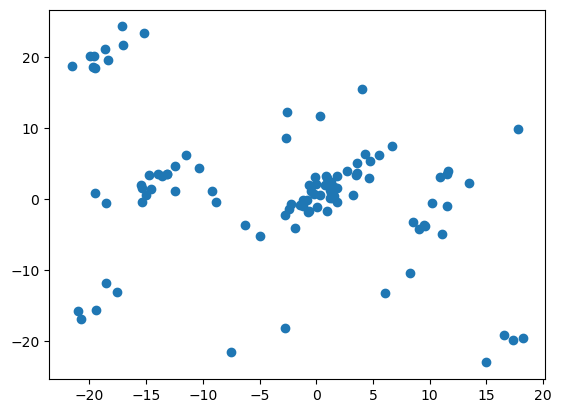

In [24]:
# Generate the samples from the Gaussion-Gaussion distribution
samples = np.zeros((n_samples, num_of_gaussian_dim)) # initialize the data matrix
z_params = np.zeros(n_samples, dtype=int) # initilize the z parameter

for i in range(n_samples):
    z_params[i] = np_rand.choice(k, p=theta_params) # assign a cluster to each sample point
    samples[i] = np_rand.multivariate_normal(eta_params[z_params[i]], cov) # draw a Sample point from the assigned cluster

# print("Samples: \n", samples)
plt.scatter(samples[:,0],samples[:,1])

In [25]:
import itertools
import matplotlib as mpl
from scipy import linalg

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange", "grey", "green"])

def plot_results(X, Y_, means, covariances, title):
    """
    Plot gaussian components as ellipses
    """
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # covar = np.diag(covar)
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.3)
        splot.add_artist(ell)
    plt.title(title)

In [26]:
# The scipy BGM do not provide a variance-fixed gaussian component option. 
bgm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=None, n_init=1, covariance_type="full", max_iter=1000, verbose=2)
bgm.fit(samples)

Initialization 0
  Iteration 10	 time lapse 0.03199s	 ll change 0.94177
Initialization converged: True	 time lapse 0.04400s	 ll -648.61815


BayesianGaussianMixture(max_iter=1000, n_components=20, verbose=2)

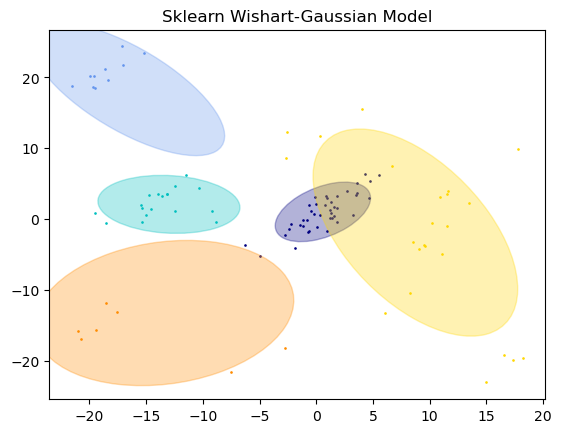

In [27]:
plot_results(samples, bgm.predict(samples), bgm.means_, bgm.covariances_, "Sklearn Wishart-Gaussian Model")

### Spherical covariance model

In [28]:
from scipy.special import logsumexp

M = 51

def plot_contour(model, x, x_min, x_max, y_min, y_max):
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, M), np.linspace(y_min, y_max, M))
    
    xy = np.stack((xv, yv), axis=-1).reshape((M * M, 2))
    prob = logsumexp(model.predict(xy), axis=1)
    z = np.reshape(prob, (M, M))

    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], 0.8)
    CS = plt.contour(xv, yv, z)
    plt.clabel(CS)
    plt.show()
    

Iter  0 elbo = -1111.5430430723711
Iter  10 elbo = -835.1877106402945
Iter  20 elbo = -806.5762363734822
Iter  30 elbo = -800.136898649265
Iter  40 elbo = -794.0472327519171
Iter  50 elbo = -793.4689026529047
Iter  60 elbo = -787.703548029996
Converge at iter 60
ELBO = -787.703548029996


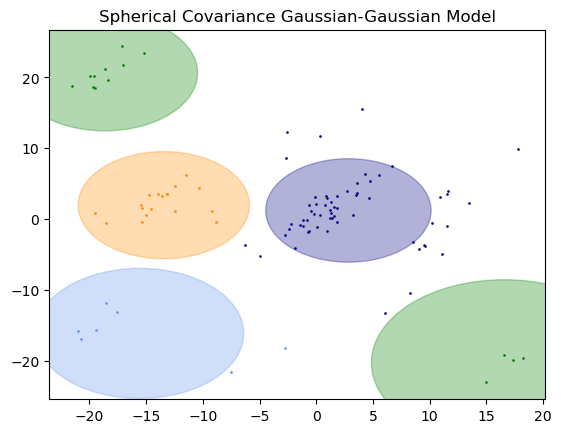

In [29]:
# Our model assume a fixed covariance in each component
from dp import *

eps = 1e-3
var_samples = np.var(samples, axis=0)
mu_samples = np.mean(samples, axis=0)

# Initialization
sigma0 = (np.prod(var_samples) ** 0.5) # Variance on each dimension, in each component
sigma = sigma0 / k # Baseline variance, on each dimension
dp = DpGaussianSpherical(samples, alpha=1e0, sigma=sigma, mu0=mu_samples, sigma0=sigma0, K=k)

elbo = - np.inf

# CAVI update
for i in range(1000):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if i % 10 == 0:
        print("Iter ", i, "elbo =", elbo)
    if abs(elbo - prev_elbo) < eps:
        print("Converge at iter", i)
        break

print("ELBO =", elbo)
prob = dp.predict(samples)
label = np.argmax(prob, axis=1)

sigma_x = np.zeros((k, 2, 2))
for i in range(k):
    sigma_x[i] = np.identity(2) * (dp.sigma ** 2 + dp.sigma_p[i] ** 2)

plot_results(samples, label, dp.mu_p, sigma_x, "Spherical Covariance Gaussian-Gaussian Model")

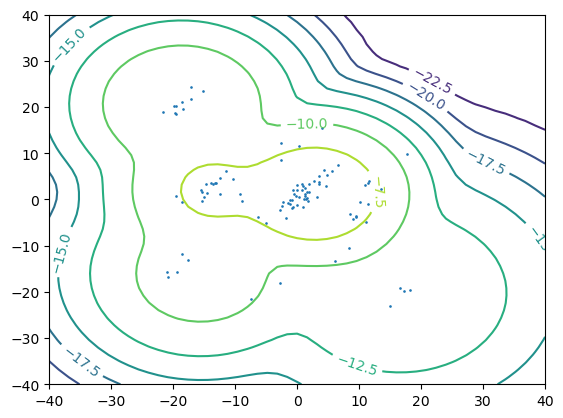

In [30]:
plot_contour(dp, samples, -40, 40, -40, 40)

### Full covariance model

Iter  0 elbo = -9137.512652897338
Iter  10 elbo = -1290.625922807441
Iter  20 elbo = -1286.584964383245
Iter  30 elbo = -1286.293849864209
Iter  40 elbo = -1286.2006255172075
Iter  50 elbo = -1286.166461929763
Iter  60 elbo = -1286.1452921615223
Iter  70 elbo = -1286.1231518384793
Iter  80 elbo = -1286.0787976761385
Iter  90 elbo = -1285.5867790945542
Iter  100 elbo = -1282.9283084620697
Converge at iter 106
ELBO = -1282.920185105585


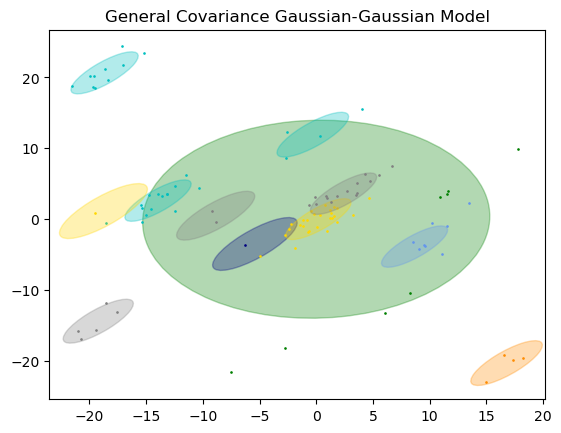

In [31]:

# Initialization
cov_samples = np.cov(samples.T)
# Sigma = np.diag(var_samples) / k ** 0.5 # Covariance matrix of each component
Sigma = cov # Covariance matrix of each component
Sigma0 = np.diag(var_samples) # Baseline covariance
# Sigma0 = base_cov # Baseline covariance
dp = DpGaussianFull(samples, alpha=1e0, Sigma=Sigma, mu0=np.zeros((2,)), Sigma0=Sigma0, K=k)

elbo = - np.inf

# CAVI update
for i in range(1000):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if i % 10 == 0:
        print("Iter ", i, "elbo =", elbo)
    if abs(elbo - prev_elbo) < eps:
        print("Converge at iter", i)
        break

print("ELBO =", elbo)
prob = dp.predict(samples)
label = np.argmax(prob, axis=1)
plot_results(samples, label, dp.mu_p, dp.Sigma + dp.Sigma_p, "General Covariance Gaussian-Gaussian Model")

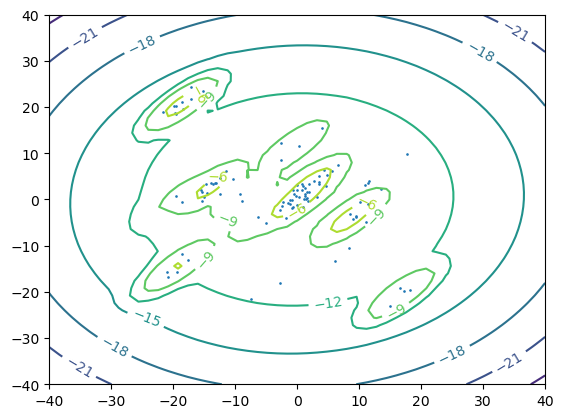

In [32]:
plot_contour(dp, samples, -40, 40, -40, 40)

## Robot data

In [33]:
from scipy.io import arff
import time

data, meta = arff.loadarff("dataset/dataset_2175_kin8nm.arff")
data = np.lib.recfunctions.structured_to_unstructured(data)

train_size = 7000
heldout_size = 250

train_data = data[0:train_size, 0:8]
cov_data = np.cov(train_data.T)
var_data = np.var(train_data, axis=0)
mean_data = np.mean(train_data, axis=0)

In [46]:
k = 20
eps = 1e-2
dp = DpGaussianFull(train_data, alpha=1e3, Sigma=cov_data, mu0=mean_data, Sigma0=np.diag(var_data), K=k)

elbo = - np.inf

# CAVI update
for i in range(1000):
    dp.update()

    if i % 10 == 0:
        elbo = dp.elbo()
        print("Iter ", i, "elbo =", elbo)

        if abs(elbo - prev_elbo) < eps:
            print("Converge at iter", i)
            break
        prev_elbo = elbo

Iter  0 elbo = -78846.75583326507
Iter  10 elbo = -78125.55478955516
Iter  20 elbo = -77950.51291981337
Iter  30 elbo = -77835.55019646535
Iter  40 elbo = -77835.55019646585
Converge at iter 40


In [47]:
heldout_data = data[train_size: train_size + heldout_size, 0:8]

prob = dp.predict(heldout_data)
label = np.argmax(prob, axis=1)

comp = 0
for i in range(k):
    if np.any(label == i):
        comp += 1
print("Number of components:", comp)

print("Held-out likelihood:", np.sum(logsumexp(prob, axis=1)))

Number of components: 1
Held-out likelihood: -2644.6079590939153
